In [1]:
# !pip install fbprophet

# ! pip uninstall fbprophet


In [2]:
# ! pip install Cython numpy
# ! pip install prophet

In [26]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime, timedelta
import pandas as pd
from prophet import Prophet
from apikey import YOUR_API_KEY


# Initialize the client (no keys required for crypto data)
client = CryptoHistoricalDataClient()

# Set up the request parameters
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

request_params = CryptoBarsRequest(
    symbol_or_symbols=["ETH/USD"],
    timeframe=TimeFrame.Day,
    start=start_date,
    end=end_date
)

# Get the crypto bars data
bars = client.get_crypto_bars(request_params)

# Convert to a pandas DataFrame for easy analysis
df = bars.df
df = df.reset_index()

# Prepare the data for Prophet
btc_data = df[['timestamp', 'close']].copy()
btc_data.rename(columns={'timestamp': 'ds', 'close': 'y'}, inplace=True)
# btc_data['ds'] = pd.to_datetime(btc_data['ds'])
btc_data['ds'] = pd.to_datetime(btc_data['ds']).dt.tz_localize(None)


14:22:39 - cmdstanpy - INFO - Chain [1] start processing
14:22:39 - cmdstanpy - INFO - Chain [1] done processing


                     ds         yhat   yhat_lower   yhat_upper
390 2025-03-21 06:00:00  2569.561859  2257.160282  2893.073026
391 2025-03-22 06:00:00  2565.729019  2225.159358  2887.045457
392 2025-03-23 06:00:00  2533.838626  2195.032001  2876.830555
393 2025-03-24 06:00:00  2549.907181  2218.774124  2874.353984
394 2025-03-25 06:00:00  2517.447031  2190.300555  2877.156821


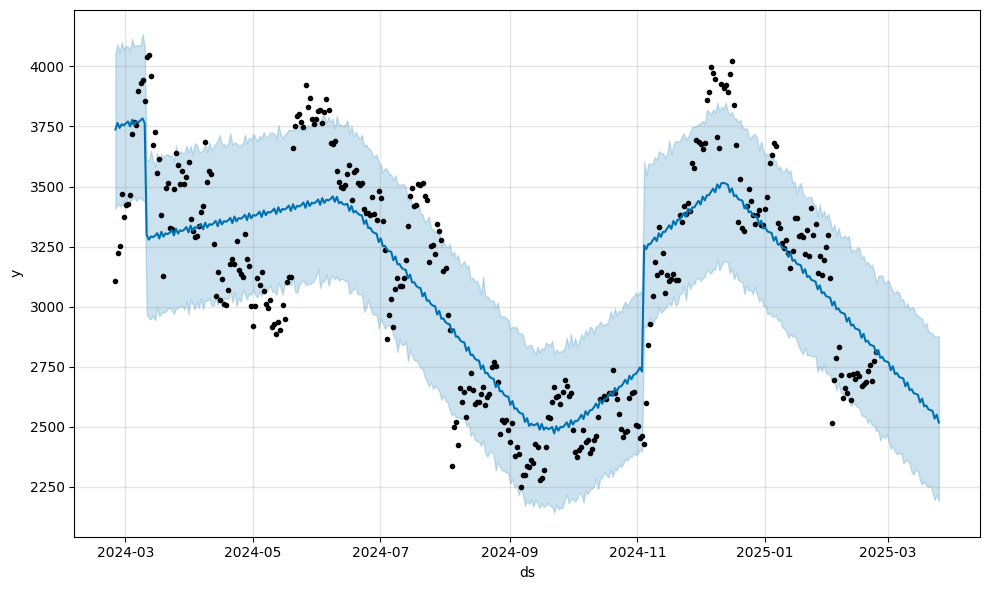

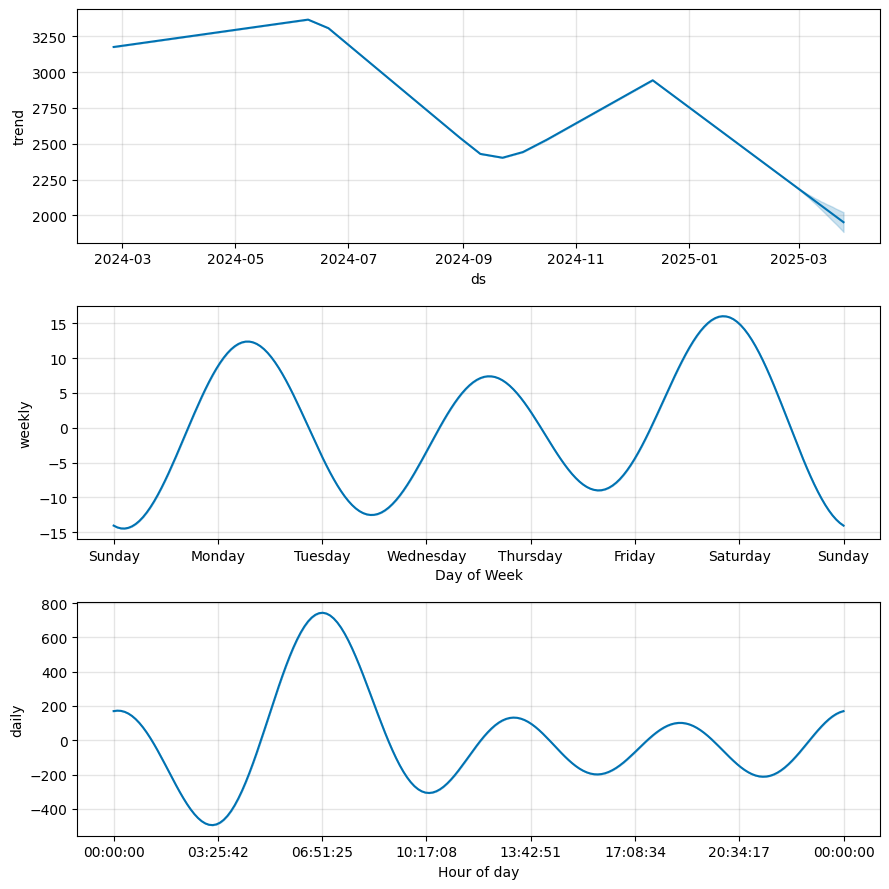

In [27]:
# Initialize and fit the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(btc_data)

# Create a dataframe for future dates
future_dates = model.make_future_dataframe(periods=30)  # Forecast 30 periods ahead

# Make predictions
forecast = model.predict(future_dates)

# Display the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the forecast
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)


14:22:40 - cmdstanpy - INFO - Chain [1] start processing
14:22:40 - cmdstanpy - INFO - Chain [1] done processing


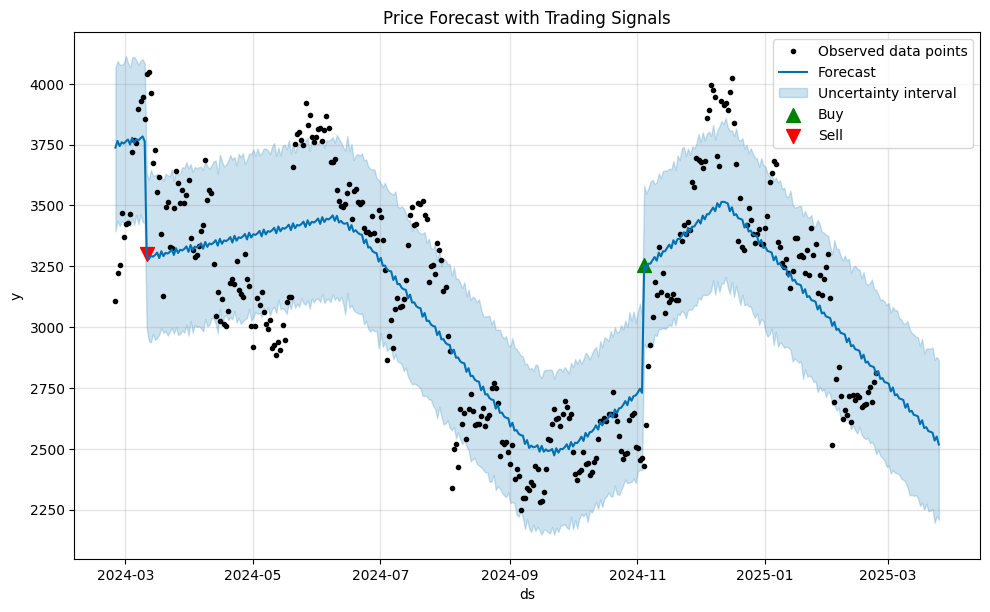


Last 7 days of signals:
                     ds         yhat signal
388 2025-03-19 06:00:00  2588.753031   Hold
389 2025-03-20 06:00:00  2572.377758   Hold
390 2025-03-21 06:00:00  2569.561859   Hold
391 2025-03-22 06:00:00  2565.729019   Hold
392 2025-03-23 06:00:00  2533.838626   Hold
393 2025-03-24 06:00:00  2549.907181   Hold
394 2025-03-25 06:00:00  2517.447031   Hold


In [28]:
# First install the required package
# Run in terminal: pip install prophet

import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Initialize and fit the Prophet model with daily seasonality
model = Prophet()
model.fit(btc_data[['ds', 'y']])  # Ensure proper column names

# Generate future dates and forecast
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Generate trading signals based on predicted trend
forecast['signal'] = 'Hold'
for i in range(1, len(forecast)):
    current = forecast.iloc[i]
    previous = forecast.iloc[i-1]
    
    # Buy when prediction increases above upper confidence bound
    if current['yhat'] > previous['yhat_upper']:
        forecast.at[current.name, 'signal'] = 'Buy'
    # Sell when prediction drops below lower confidence bound
    elif current['yhat'] < previous['yhat_lower']:
        forecast.at[current.name, 'signal'] = 'Sell'

# Plot results with signals
fig = model.plot(forecast)
ax = fig.gca()

# Add buy/sell markers
buy_dates = forecast[forecast['signal'] == 'Buy']['ds']
sell_dates = forecast[forecast['signal'] == 'Sell']['ds']
ax.scatter(buy_dates, forecast.loc[forecast['ds'].isin(buy_dates), 'yhat'], 
           marker='^', color='g', s=100, label='Buy')
ax.scatter(sell_dates, forecast.loc[forecast['ds'].isin(sell_dates), 'yhat'],
           marker='v', color='r', s=100, label='Sell')

plt.title("Price Forecast with Trading Signals")
plt.legend()
plt.show()

# Display signal summary
print("\nLast 7 days of signals:")
print(forecast[['ds', 'yhat', 'signal']].tail(7))


In [29]:
def AIopinion(messages):
    from openai import OpenAI
    
    import re
    from IPython.display import clear_output
    
    client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")
    
    try:
        response_stream = client.chat.completions.create(
            model="sonar-pro", #sonar-pro #sonar-reasoning-pro #sonar #sonar-reasoning
            messages=messages,
            stream=True,
        )
    
        full_response = []
        link_map = {}
        link_counter = 1
        buffer = ""
    
        for chunk in response_stream:
            if hasattr(chunk, 'citations') and chunk.citations:
                # Enumerate URLs starting at index 1 for proper citation numbering
                link_map = {str(i): url for i, url in enumerate(chunk.citations, start=1)}
            if chunk.choices and chunk.choices[0].delta.content:
                content = chunk.choices[0].delta.content
                buffer += content
                
                # Process URLs incrementally
                while True:
                    match = re.search(r'https?://[^\s\)\]\}]+', buffer)
                    if not match:
                        break
                        
                    url = match.group()
                    if url not in link_map:
                        link_map[url] = link_counter
                        link_counter += 1
                    
                    # Replace URL with reference marker
                    buffer = buffer.replace(url, f'[{link_map[url]}]', 1)
                
                # Print processed content and clear buffer
                print(buffer, end='', flush=True)
                full_response.append(buffer)
                buffer = ""
    
        # Print remaining buffer content
        if buffer:
            print(buffer, end='', flush=True)
            full_response.append(buffer)
    
        # Add references appendix
        print("\n\n--- References ---")
        for url, num in sorted(link_map.items(), key=lambda x: x[1]):
            print(f"[{num}] {url}")
    
    except Exception as e:
        clear_output()
        print(f"Error occurred: {str(e)}")

In [30]:
messages = [{
    "role": "user",
    "content": f"""Analyze this data, This is Facebook's prophet model 
    Look at day of week seasonality, hourly seasonality, talk about the future direction of the stock.
    
    ## 
    {forecast.to_markdown()}
    """
}]
AIopinion(messages=messages)

Based on the Facebook Prophet model data provided, I can analyze the following aspects:

Day of Week Seasonality:
The model shows clear day-of-week seasonality patterns:

1. Mondays (weekday 1) have the highest positive effect, with an average increase of about 12.3361.
2. Tuesdays (weekday 2) show the largest negative effect, with an average decrease of about -10.5085.
3. Wednesdays (weekday 3) have a small positive effect of about 3.10443.
4. Thursdays (weekday 4) show a slight negative effect of about -3.65533.
5. Fridays (weekday 5) have a small positive effect of about 3.14428.
6. Saturdays (weekday 6) show a significant positive effect of about 8.92695.
7. Sundays (weekday 7) have the second-largest negative effect of about -13.3479.

This suggests that the stock tends to perform best on Mondays and Saturdays, while it tends to underperform on Tuesdays and Sundays.

Hourly Seasonality:
The data provided does not show hourly seasonality effects. All predictions are made for 6:00 A